In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
df = pd.DataFrame()
for year in range(2004, 2024):
    m = pd.read_pickle(f"../data/external/base_athle_{year}.pkl")
    f = pd.read_pickle(f"../data/external/base_athle_{year}_F.pkl")
    m.Sex = 'M'
    f.Sex = 'F'
    df = pd.concat([df, m, f])
df = df.dropna(subset=["Time"])

In [23]:
def parse_time_to_seconds(time_str):
    time_str = time_str.replace(' (F)', '')
    time_str = time_str.replace(' (00m)', '')
    if ':' in time_str:
        try:
            t = pd.to_datetime(time_str, format='%H:%M:%S')
        except ValueError:
            t = pd.to_datetime(time_str, format='%M:%S')
    elif 'h' in time_str:
        t = pd.to_datetime(time_str, format='%Hh%M\'%S\'\'')
    else:
        try:
            t = pd.to_datetime(time_str, format='%M\'%S\'\'')
        except ValueError:
            try:
                t = pd.to_datetime(time_str, format='%M\'%S\'\'%f')
            except:
                try:
                    t = pd.to_datetime(time_str, format='%S\'\'%f')
                except:
                    return np.nan
            
    total_seconds = t.hour * 3600 + t.minute * 60 + t.second + t.microsecond / 1e6
    
    return total_seconds

def get_full_year(year_last_two_digits):
    try:
        year_last_two_digits = int(year_last_two_digits)
    except:
        return np.nan
    
    if year_last_two_digits < 10:
        return 2000 + year_last_two_digits
    else:
        return 1900 + year_last_two_digits

In [24]:
df['Seconds'] = df['Time'].apply(parse_time_to_seconds)
df['Birth Year'] = df['Birth Year'].apply(get_full_year)
df['Event Date'] = df['Date'].apply(lambda x: pd.to_datetime(x, format='%d/%m/%y'))
df['Event Year'] = df['Event Date'].dt.year
df['Age'] = df['Event Year'] -  df['Birth Year']

In [25]:
df.to_pickle('../data/processed/base_athle.pkl')

In [26]:
df = pd.read_pickle('../data/processed/base_athle.pkl')

In [ ]:
df = df.drop(
    columns=[
        "Sex",
        "Club",
        "Region",
        "Department",
        "Date",
        "Category",
        "Event Date",
        "Event Year",
        "Place",
        "Time",
    ]
)

<AxesSubplot: title={'center': 'Age'}, xlabel='Distance'>

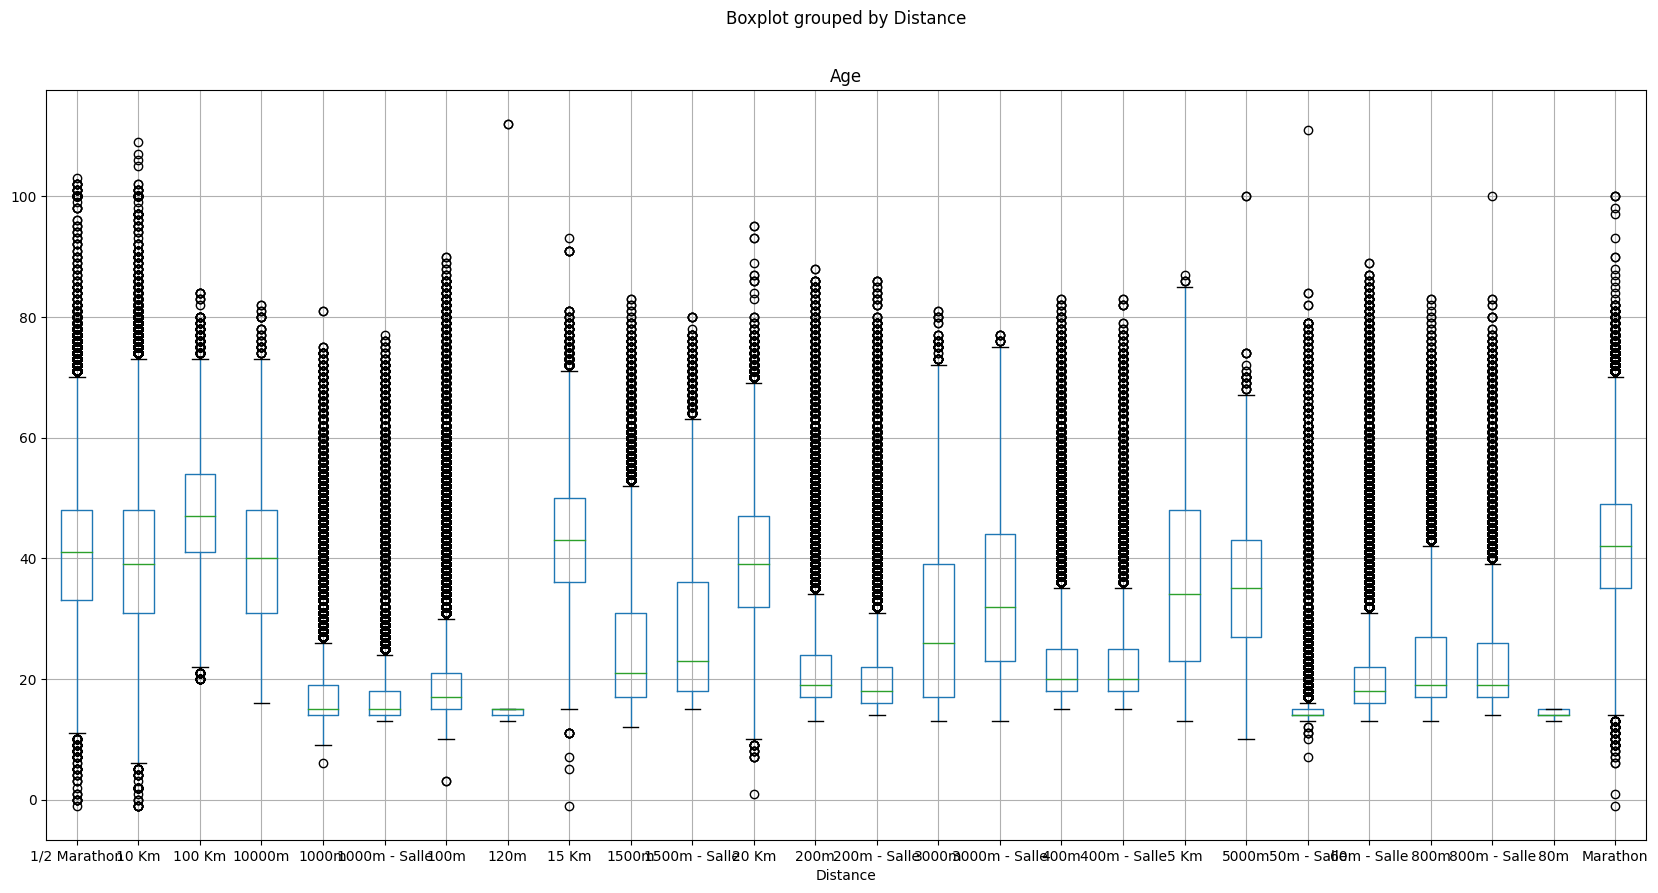

In [14]:
df.boxplot(column='Age', by='Distance', figsize=(20, 10))

In [91]:
records = df.groupby(['Distance', 'Name', 'Birth Year']).agg({'Seconds': 'min'}).reset_index()

In [92]:
best_times = pd.merge(
    records, df, on=["Distance", "Name", "Birth Year", "Seconds"], how="inner"
).drop_duplicates(subset=["Distance", "Name", "Birth Year", "Seconds"])
best_times.Age = best_times.Age.astype(int)

<AxesSubplot: title={'center': 'Age'}, xlabel='Distance'>

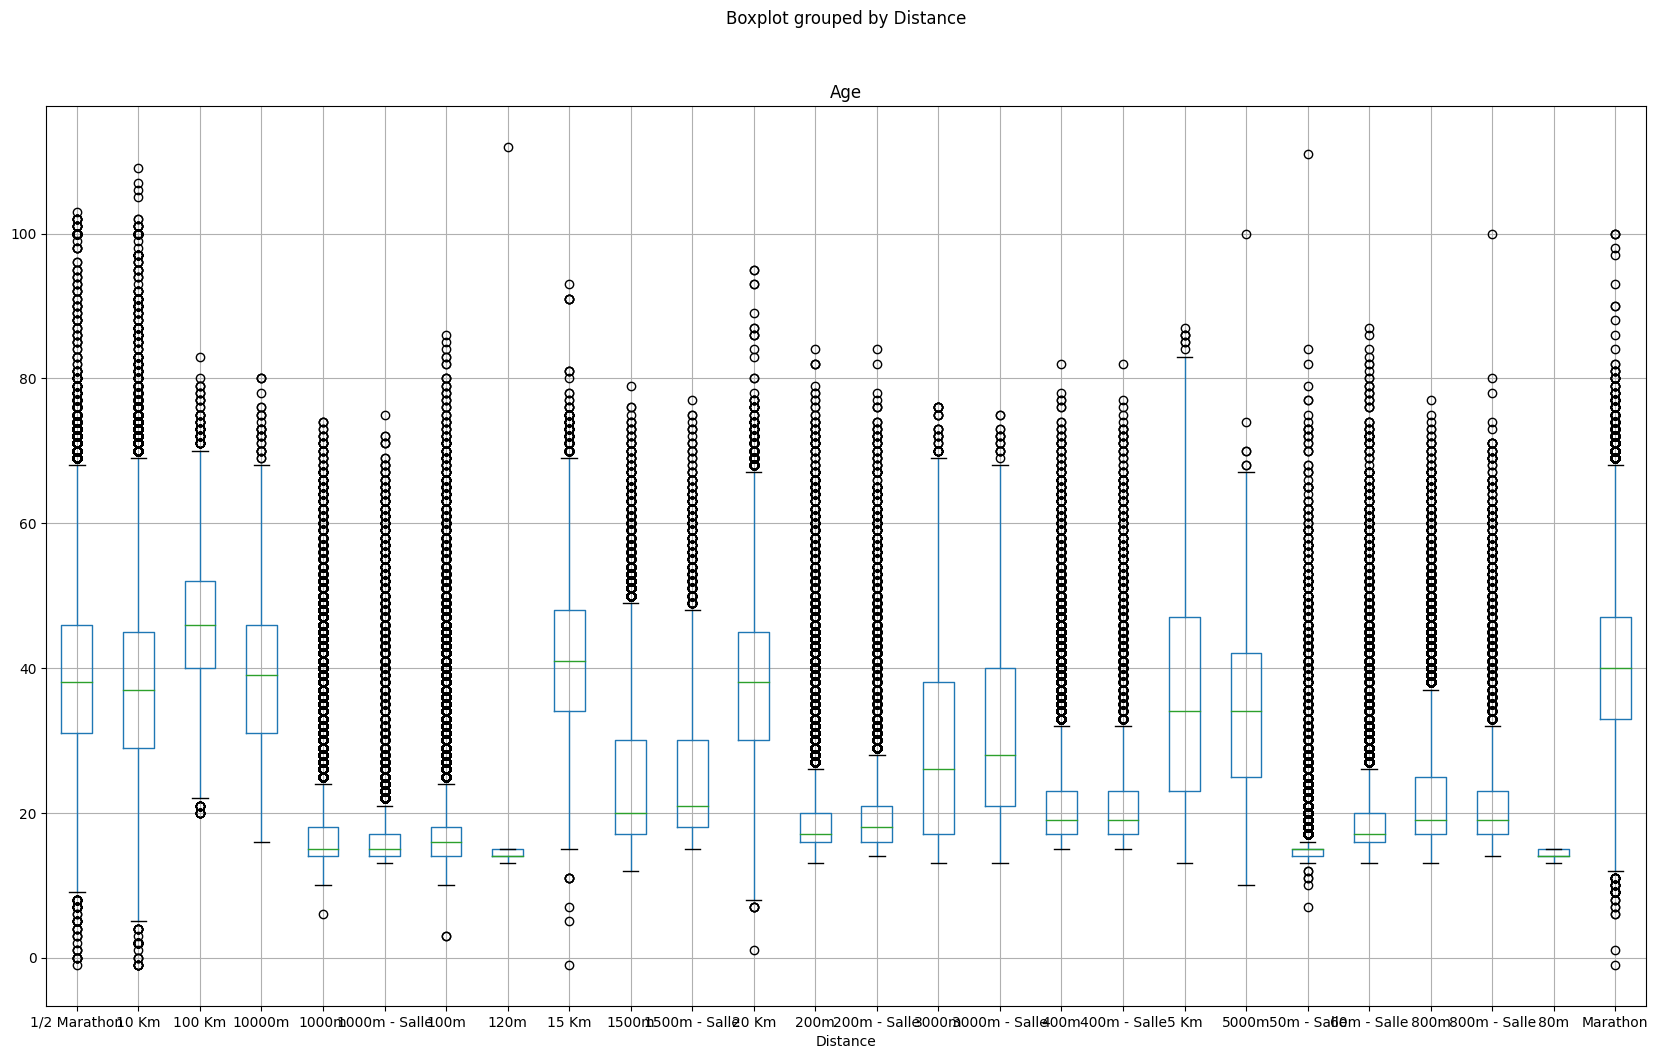

In [93]:
best_times.boxplot(column='Age', by='Distance', figsize=(20, 12))

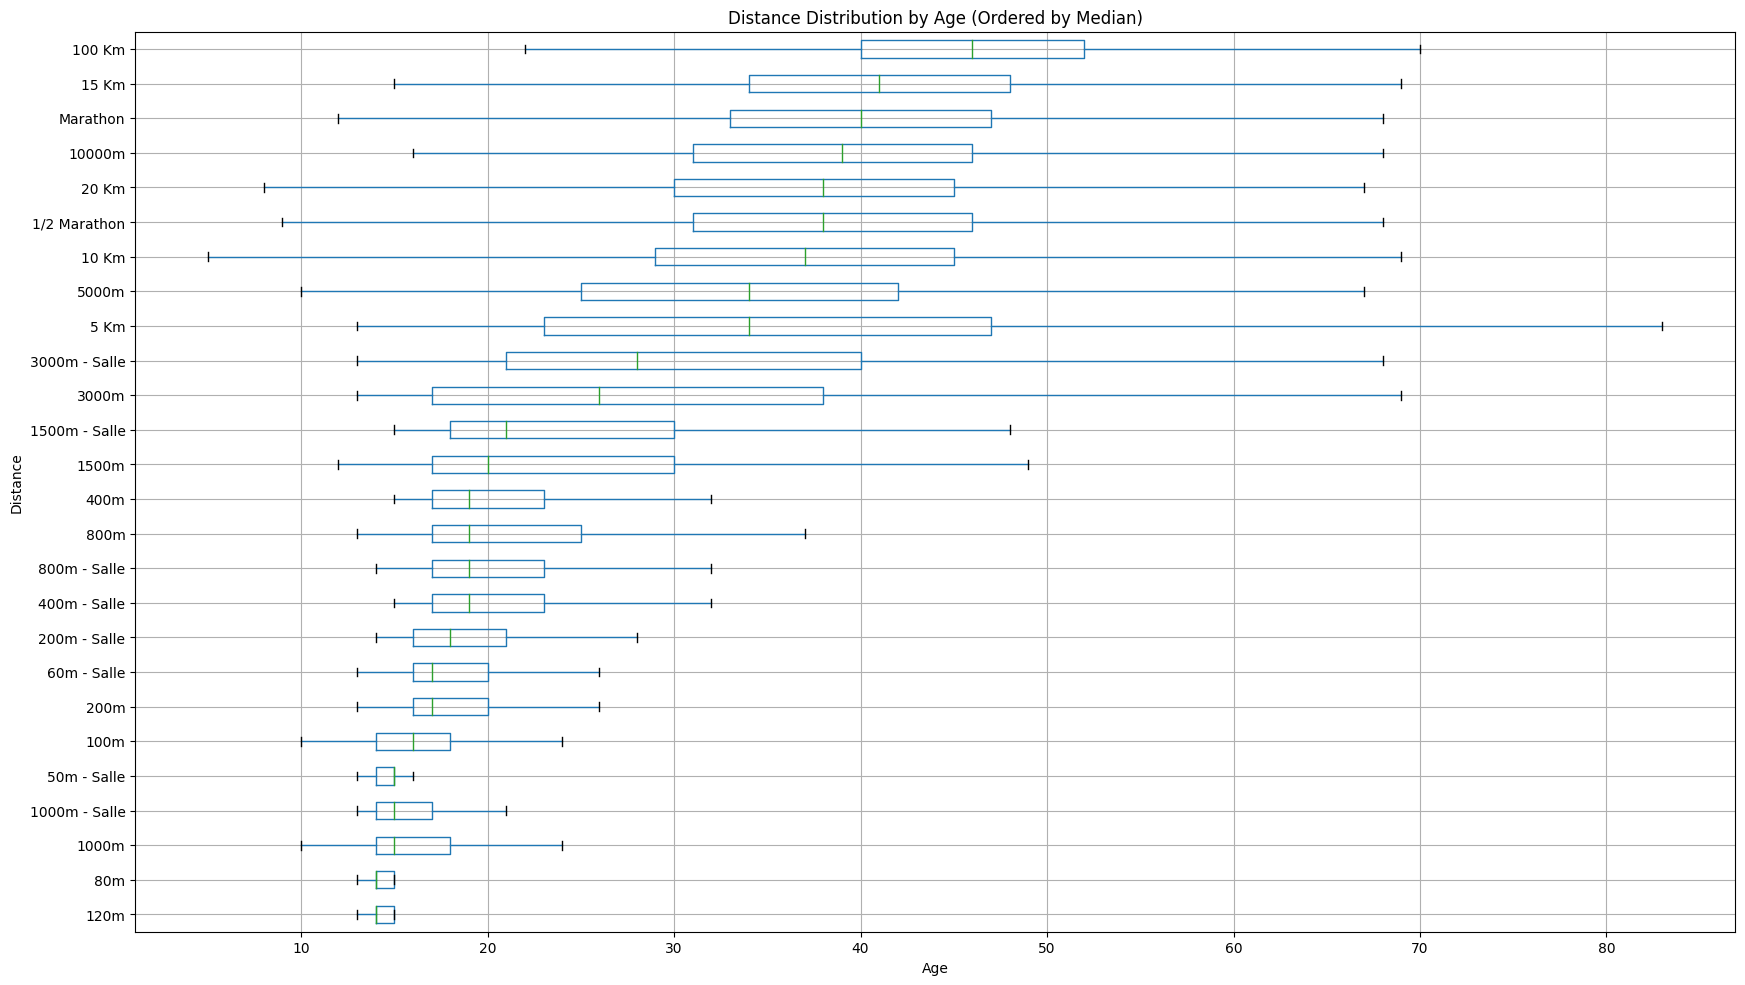

In [94]:
import matplotlib.pyplot as plt

# Calculate the median values for each category
median_values = best_times.groupby("Distance")["Age"].median().sort_values()

# Create a custom order for the categories based on the median values
category_order = median_values.index

# Reorder the categories in the DataFrame
best_times["Distance"] = pd.Categorical(best_times["Distance"], category_order)

# Create the boxplot
fig, ax = plt.subplots(figsize=(20, 12))
best_times.boxplot(column="Age", by="Distance", ax=ax, showfliers=False, vert=False)

# Set the title and labels for the plot
plt.title("Distance Distribution by Age (Ordered by Median)")
plt.xlabel("Age")
plt.ylabel("Distance")
plt.suptitle("")

# Show the plot
plt.show()

In [102]:
df.loc[
    (df["Distance"] == "Marathon") & (df["Seconds"] <= parse_time_to_seconds("2h15'00''"))
].sort_values(by="Seconds")

,Name,Birth Year,Distance,Seconds,Age
0,AMDOUNI Morhad,1988.0,Marathon,7522.0,34.0
0,NAVARRO Nicolas,1991.0,Marathon,7604.0,32.0
0,TAMBWE NGOLE Patrick,1975.0,Marathon,7650.0,37.0
1,CHAHDI Hassan,1989.0,Marathon,7691.0,33.0
2,NAVARRO Nicolas,1991.0,Marathon,7709.0,31.0
...,...,...,...,...,...
1,THEURI James Kibocha,1978.0,Marathon,8088.0,36.0
5,PERRILLAT Duncan,1993.0,Marathon,8089.0,28.0
4,BOMMIER Timothee,1986.0,Marathon,8090.0,31.0
5,MEFTAH Abdellatif,1982.0,Marathon,8095.0,35.0


In [95]:
# %% cell 12

marathon_best_times = best_times[best_times["Distance"] == "Marathon"]
under_2h28 = marathon_best_times[marathon_best_times["Seconds"] < 2 * 60 * 60 + 46 * 60 + 6]
under_2h28_marathoners = under_2h28[["Name", "Birth Year"]].drop_duplicates()

In [43]:
def format_seconds(value, pos=0):
    hours = value // 3600
    minutes = (value % 3600) // 60
    seconds = value % 60
    return f"{int(hours)}:{int(minutes):02.0f}:{int(seconds):02.0f}"

In [87]:
under_2h28_marathoners_records = pd.merge(
    best_times, under_2h28_marathoners, on=["Name", "Birth Year"], how='left'
)

In [104]:
df.loc[df['Distance'] == 'Marathon']

,Name,Birth Year,Distance,Seconds,Age
0,ZWIERZCHIEWSKI Benoit,1976.0,Marathon,7775.0,28.0
1,LAHSSINI El Hassan,1975.0,Marathon,7810.0,29.0
2,EL HIMER Driss,1974.0,Marathon,7915.0,30.0
3,BAGY Hakim,1968.0,Marathon,7992.0,36.0
4,JAOUANE Hamid,1970.0,Marathon,8119.0,34.0
...,...,...,...,...,...
37,DELAGE Bernard,1959.0,Marathon,18896.0,64.0
38,SARFATI Vincent,1972.0,Marathon,18898.0,51.0
39,PELLARIN Vincent,1982.0,Marathon,18898.0,41.0
40,GILABER Logan,2003.0,Marathon,18899.0,20.0


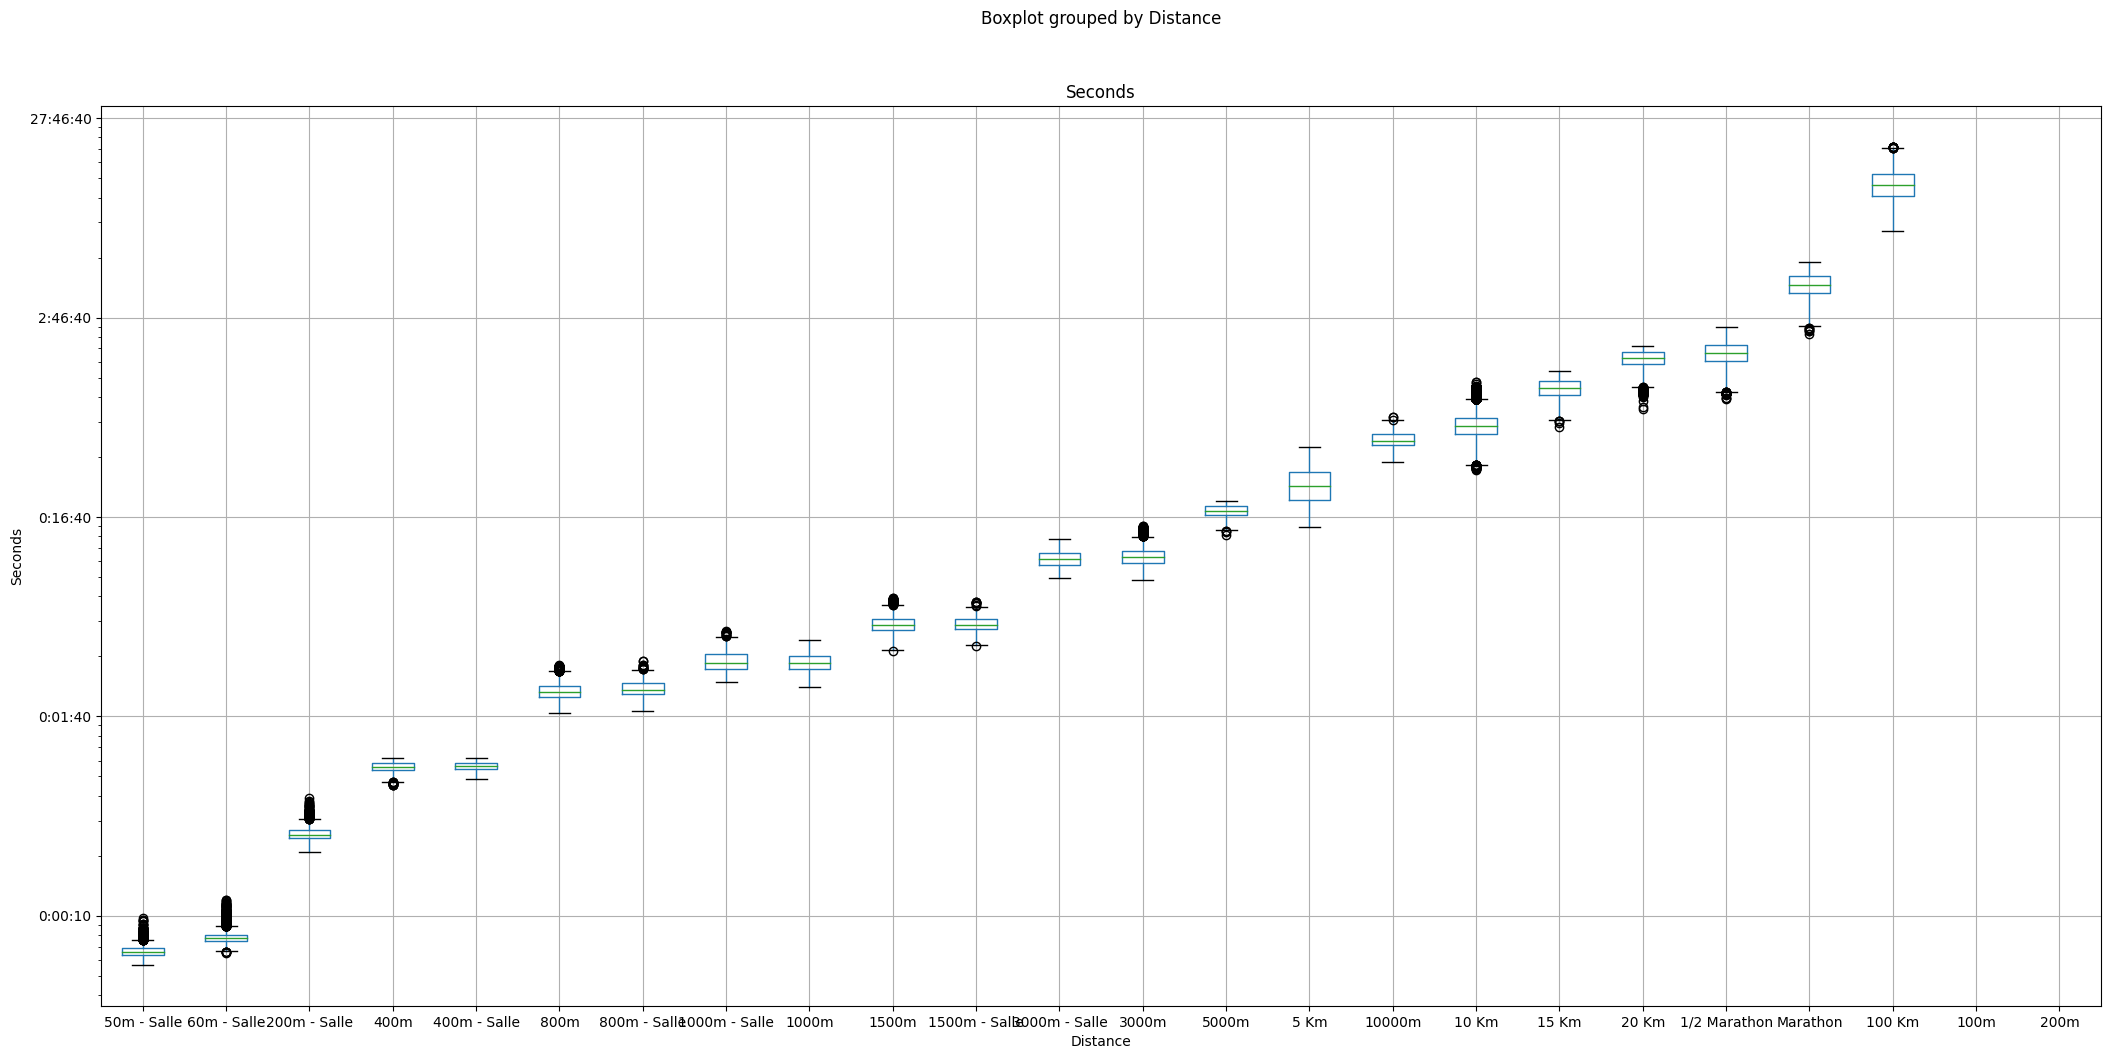

In [89]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


def format_seconds(value, pos=0):
    hours = value // 3600
    minutes = (value % 3600) // 60
    seconds = value % 60
    return f"{int(hours)}:{int(minutes):02.0f}:{int(seconds):02.0f}"


formatter = ticker.FuncFormatter(format_seconds)

# Calculate the median values for each category
median_values = (
    under_2h28_marathoners_records.groupby("Distance")["Seconds"].median().sort_values()
)

# Create a custom order for the categories based on the median values
category_order = median_values.index

# Reorder the categories in the DataFrame
under_2h28_marathoners_records["Distance"] = pd.Categorical(
    under_2h28_marathoners_records["Distance"], category_order
)

# Create the boxplot
fig, ax = plt.subplots(figsize=(25, 12))
under_2h28_marathoners_records.boxplot(column="Seconds", by="Distance", ax=ax)

# Set the title and labels for the plot
ax.set_xlabel("Distance")
ax.set_ylabel("Seconds")

# Show the plot
ax.set_yscale("log")
ax.yaxis.set_major_formatter(formatter)
plt.show()

NameError: name 'masters' is not defined

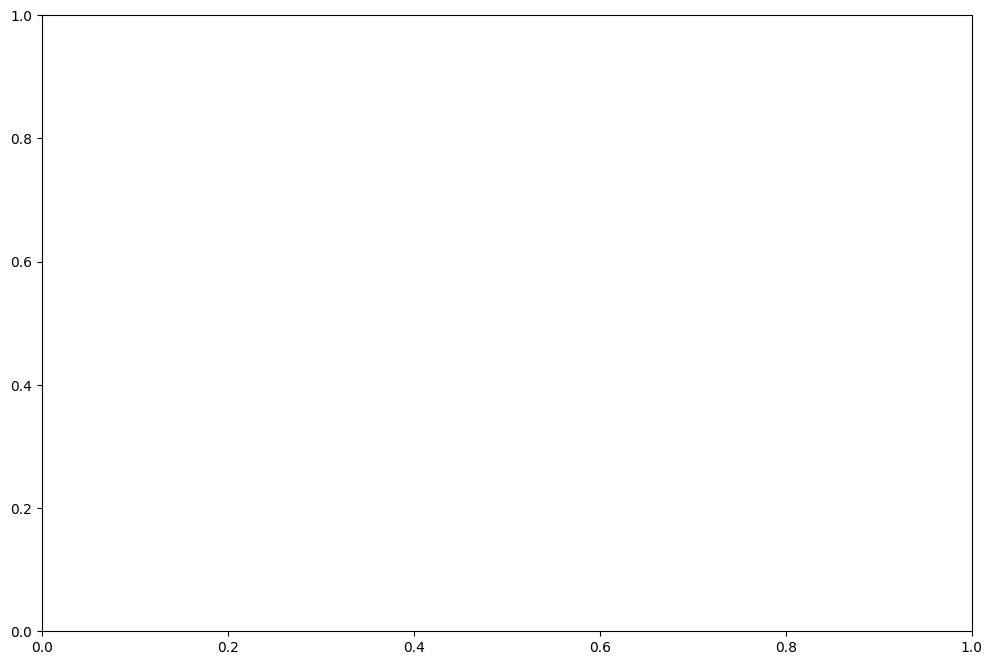

In [69]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


formatter = ticker.FuncFormatter(format_seconds)

fig, ax = plt.subplots(figsize=(12, 8))
masters.plot(x='Age', y='Seconds', kind='scatter', ax=ax, title='Masters Marathon Times')
ax.yaxis.set_major_formatter(formatter)
plt.show()

NameError: name 'masters' is not defined

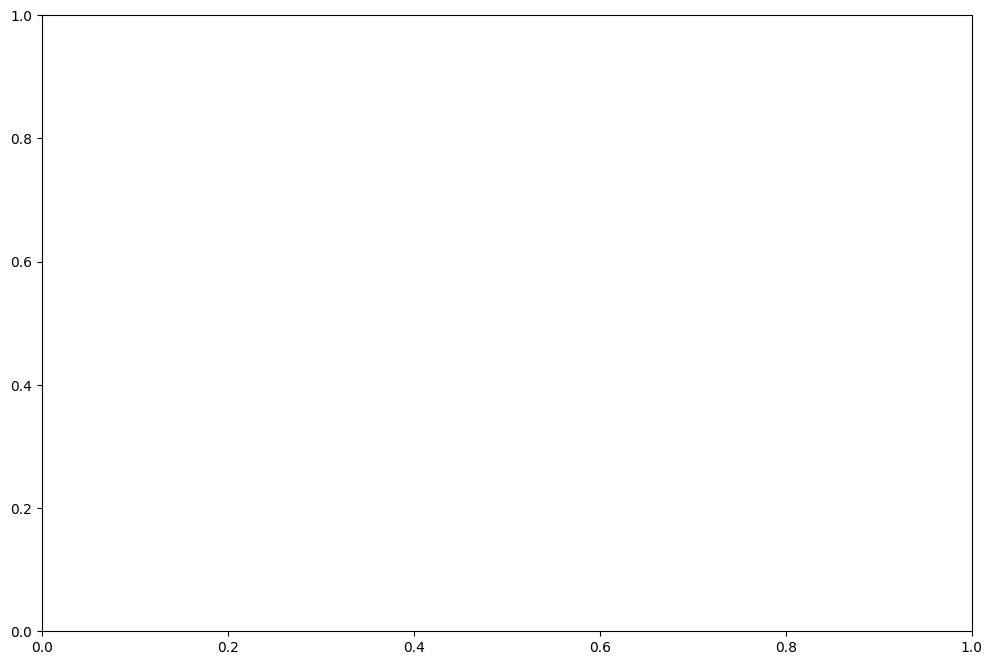

In [70]:
fig, ax = plt.subplots(figsize=(12, 8))
tmp = masters.loc[(masters.Age <= 60) & (masters.Age >= 40)]
tmp.boxplot(column='Seconds', by='Age', ax=ax)
ax.yaxis.set_major_formatter(formatter)
plt.title('Masters Marathon Times')
plt.suptitle('')  # This line removes the automatic 'Boxplot grouped by Age' title
plt.show()

In [71]:
records = df.groupby(['Name', 'Birth Year']).agg({'Seconds': 'min'}).reset_index()

In [72]:
best_times = pd.merge(records, df, on=['Name', 'Birth Year', 'Seconds'], how='inner').drop_duplicates(subset=['Name', 'Birth Year', 'Seconds'])
best_times.Age = best_times.Age.astype(int)
best_times = best_times.loc[(best_times.Age >= 18) & (best_times.Age <= 60)]

In [73]:
top_5_percent = best_times.groupby('Age')['Seconds'].apply(lambda x: x.quantile(0.0265))

In [39]:
parse_time_to_seconds("2h46'05''")

9965.0

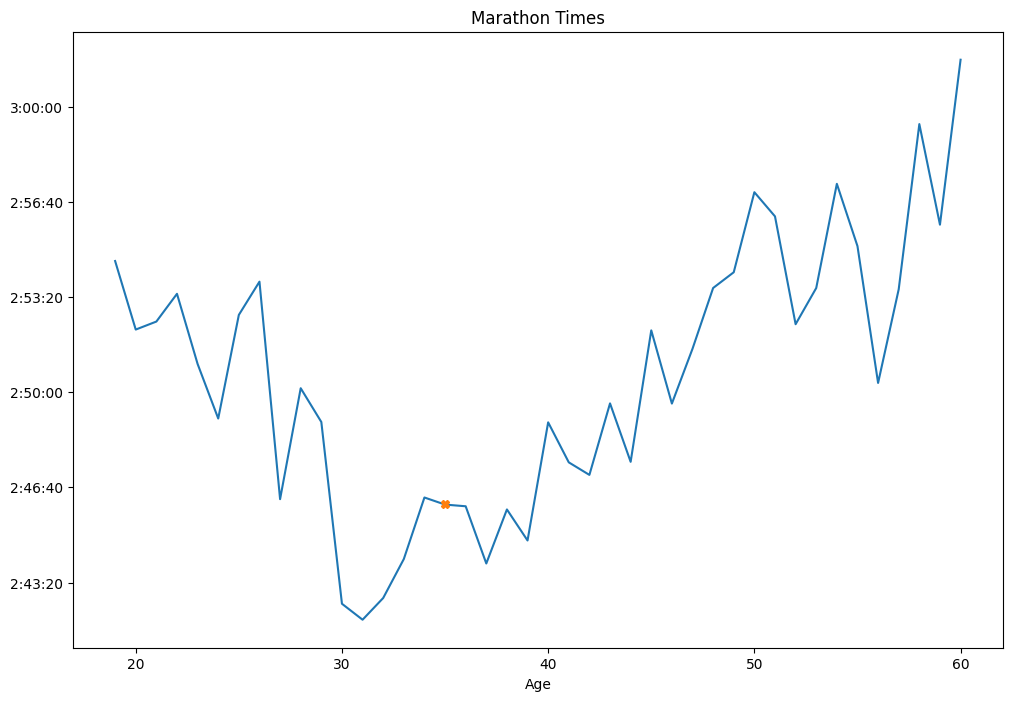

In [54]:
top_5_percent = (
    best_times.loc[
        (best_times.Distance == "Marathon")
        & (best_times.Age >= 19)
        & (best_times.Age <= 60)
    ]
    .groupby("Age")["Seconds"]
    .apply(lambda x: x.quantile(0.00275))
)

fig, ax = plt.subplots(figsize=(12, 8))
# best_times[(best_times.Age >= 18) & (best_times.Age <= 60)].boxplot(column='Seconds', by='Age', ax=ax)
top_5_percent.plot(ax=ax, title="Top 5% Times by Age")
ax.yaxis.set_major_formatter(formatter)
ax.plot(35, 9965, "X")

plt.title("Marathon Times")
plt.suptitle("")  # This line removes the automatic 'Boxplot grouped by Age' title
plt.show()

In [56]:
best_times.loc[
    (best_times.Distance == "Marathon")
    & (best_times.Age >= 19)
    & (best_times.Age <= 60)
]

,Name,Birth Year,Seconds,Distance,Age
41,***** DOSSARD Inconnu,1964.0,16494.0,Marathon,58
105,673613714 673613714,1965.0,13228.0,Marathon,53
138,AAA Louis Philippe,1952.0,13728.0,Marathon,57
143,AABADI Karim Alexandre,1972.0,13971.0,Marathon,49
145,AABALLAOUI Omar,1982.0,12742.0,Marathon,27
...,...,...,...,...,...
1640624,ZYNDA Stéphane,1975.0,12577.0,Marathon,31
1640636,ZYZELEWICZ Jan,1970.0,13902.0,Marathon,40
1640654,ÂBDALLAH Thierry,1970.0,18258.0,Marathon,39
1640656,ÉGLOFFE Joel,1955.0,13583.0,Marathon,51


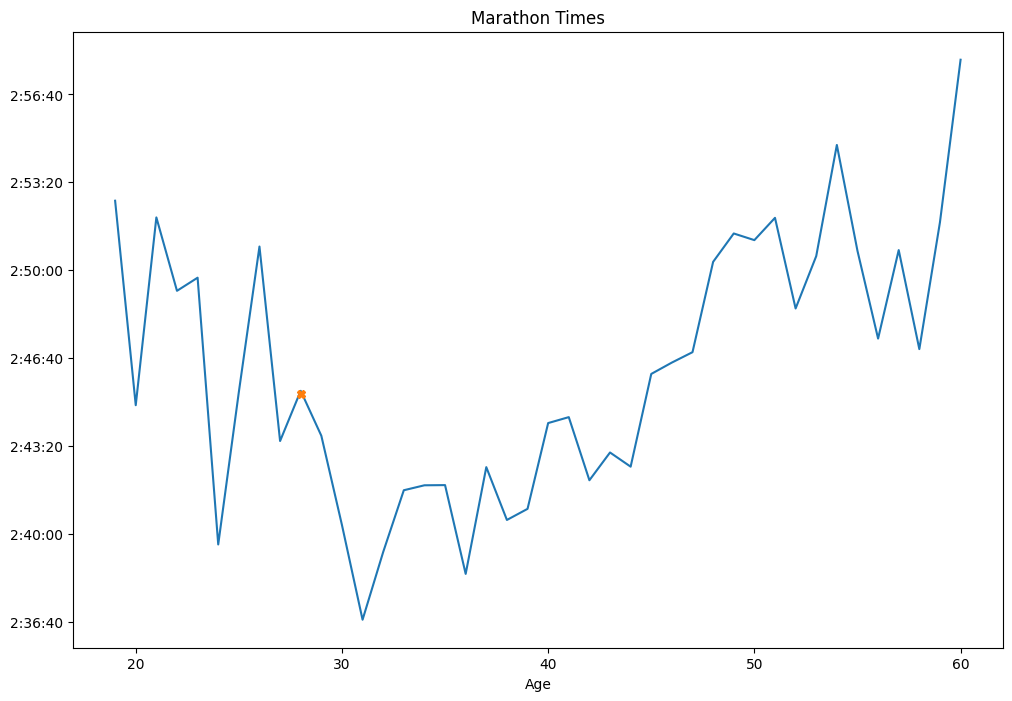

In [64]:
top_5_percent = (
    best_times.loc[
        (best_times.Distance == "Marathon") & (best_times.Age >= 19)
        & (best_times.Age <= 60)
    ]
    .groupby("Age")["Seconds"]
    .apply(lambda x: x.quantile(0.0012))
)

fig, ax = plt.subplots(figsize=(12, 8))
# best_times[(best_times.Age >= 18) & (best_times.Age <= 60)].boxplot(column='Seconds', by='Age', ax=ax)
top_5_percent.plot(ax=ax, title="Top 5% Times by Age")
ax.yaxis.set_major_formatter(formatter)
ax.plot(28, 9918, "X")

plt.title("Marathon Times")
plt.suptitle("")  # This line removes the automatic 'Boxplot grouped by Age' title
plt.show()

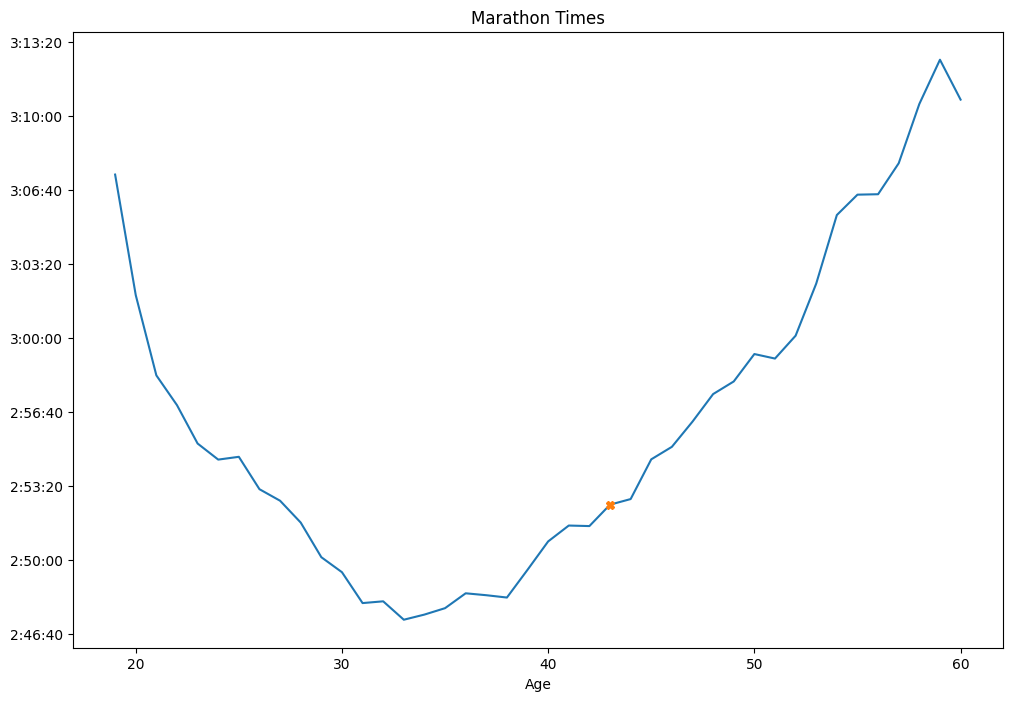

In [118]:
top_5_percent = (
    best_times.loc[
        (best_times.Distance == "Marathon")
        & (best_times.Age >= 19)
        & (best_times.Age <= 60)
    ]
    .groupby("Age")["Seconds"]
    .apply(lambda x: x.quantile(0.0261))
)

fig, ax = plt.subplots(figsize=(12, 8))
# best_times[(best_times.Age >= 18) & (best_times.Age <= 60)].boxplot(column='Seconds', by='Age', ax=ax)
top_5_percent.plot(ax=ax, title="Top 5% Times by Age")
ax.yaxis.set_major_formatter(formatter)
ax.plot(43, 10350, "X")

plt.title("Marathon Times")
plt.suptitle("")  # This line removes the automatic 'Boxplot grouped by Age' title
plt.show()

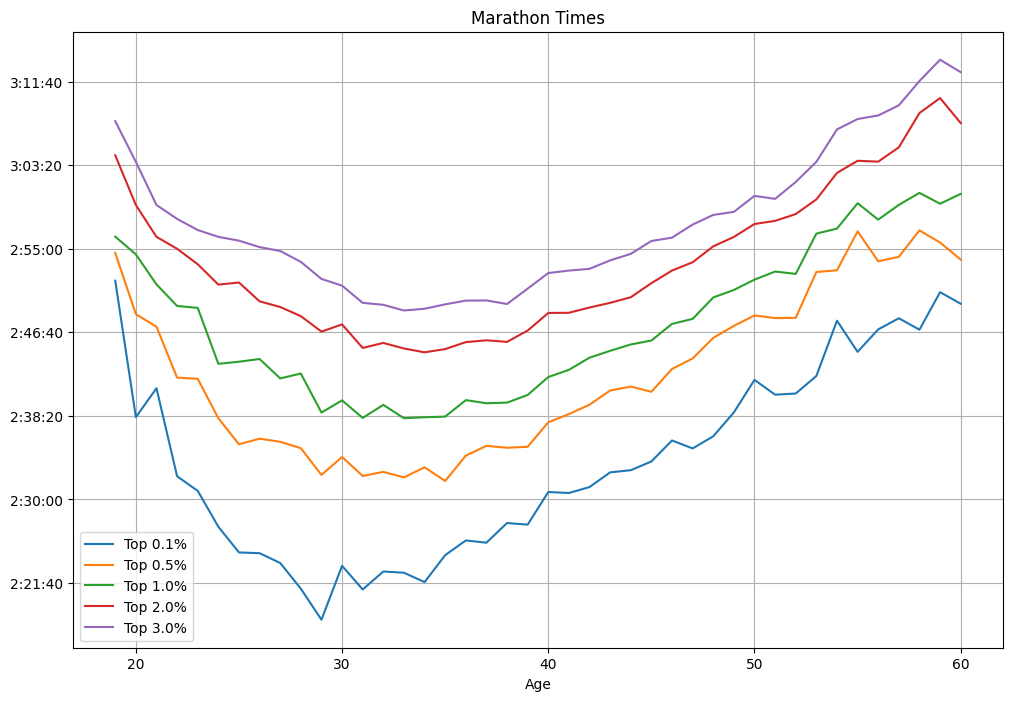

In [140]:
top_5_percent = (
    best_times.loc[
        (best_times.Distance == "Marathon")
        & (best_times.Age >= 19)
        & (best_times.Age <= 60)
    ]
    .groupby("Age")["Seconds"]
    .apply(lambda x: x.quantile([0.001, 0.005, 0.01, 0.02, 0.03]))
)

fig, ax = plt.subplots(figsize=(12, 8))
# best_times[(best_times.Age >= 18) & (best_times.Age <= 60)].boxplot(column='Seconds', by='Age', ax=ax)
for lvl in top_5_percent.reset_index().level_1.unique():
    top_5_percent.loc[:, lvl].plot(ax=ax, label=f"Top {lvl * 100:.1f}%")
ax.yaxis.set_major_formatter(formatter)
ax.grid()
plt.title("Marathon Times")
plt.suptitle("")  # This line removes the automatic 'Boxplot grouped by Age' title
plt.legend()
plt.show()

In [125]:
top_5_percent.loc[:, 0.001]

Age
19    10308.511
20     9492.082
21     9665.056
22     9138.380
23     9051.184
24     8836.564
25     8682.786
26     8678.252
27     8619.638
28     8465.876
29     8280.226
30     8602.755
31     8461.164
32     8568.768
33     8561.370
34     8505.248
35     8666.584
36     8754.532
37     8741.004
38     8858.697
39     8849.120
40     9044.218
41     9038.300
42     9073.919
43     9161.844
44     9174.875
45     9226.940
46     9352.527
47     9305.050
48     9377.550
49     9520.440
50     9715.154
51     9626.482
52     9633.532
53     9738.198
54    10069.156
55     9883.005
56    10017.108
57    10083.763
58    10015.350
59    10239.759
60    10170.744
Name: Seconds, dtype: float64

In [130]:
for elt in top_5_percent.index[0]:
    print(elt)

19
0.001


In [132]:
top_5_percent.reset_index().level_1.unique()

array([0.001, 0.005, 0.01 , 0.025, 0.05 , 0.1  ])

In [27]:
records = df.groupby(["Name", "Birth Year", 'Distance']).agg({"Seconds": "min"}).reset_index()

In [28]:
best_times = pd.merge(
    records, df, on=["Distance", "Name", "Birth Year", "Seconds"], how="inner"
).drop_duplicates(subset=["Distance", "Name", "Birth Year", "Seconds"])
best_times.Age = best_times.Age.astype(int)

In [83]:
t = best_times.loc[best_times.Distance == '10 Km'].groupby('Sex').apply(lambda x: x.quantile(0.01015))

/var/folders/8h/p7tllcw96sv_k_1rvz_4h51m0000gn/T/ipykernel_2196/2063008583.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  t = best_times.loc[best_times.Distance == '10 Km'].groupby('Sex').apply(lambda x: x.quantile(0.01015))


In [84]:
t = t.drop(columns=["Birth Year", "Event Year", "Age"])

In [85]:
t.Seconds = t.Seconds.apply(format_seconds)
t

0.01015,Seconds
Sex,
F,0:40:57
M,0:33:39


In [52]:
best_times.loc[best_times.Name == 'ROULLE Julien']

,Name,Birth Year,Distance,Seconds,Time,Sex,Club,Region,Department,Category,Date,Place,Event Date,Event Year,Age
4059076,ROULLE Julien,1986.0,1/2 Marathon,5722.0,1h35'22'',M,NL la veille de la compétition,NaN,NaN,SEM,14/10/18,Rennes,2018-10-14,2018.0,32
4059077,ROULLE Julien,1986.0,10 Km,2629.0,43'49'',M,NL la veille de la compétition,NaN,NaN,SEM,08/10/17,Rennes,2017-10-08,2017.0,31
4059078,ROULLE Julien,1995.0,10 Km,2128.0,35'28'',M,Stade Rennais Athletisme*,BRE,35.0,SEM,05/03/23,Carquefou,2023-03-05,2023.0,28
4059079,ROULLE Julien,1995.0,5 Km,1013.0,16'53'',M,Stade Rennais Athletisme*,BRE,35.0,SEM,21/04/23,Pace,2023-04-21,2023.0,28


In [86]:
import datetime

In [91]:
(datetime.date(2024, 2, 18) - datetime.date.today()).days / 7

12.571428571428571